In [2]:
from Models.U_net_tf import RSUNet
import albumentations as A
import matplotlib.pyplot as plt
#import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers,datasets
import os
import pandas as pd
import wandb
from wandb.keras import WandbCallback
from Loader.dataset import CrackDatasetTF
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
#wandb.login()

# Dataframe

In [5]:
wandb.init(project="waterGan",entity='moxx799')

wandb: Currently logged in as: moxx799. Use `wandb login --relogin` to force relogin


In [6]:

config = wandb.config

In [7]:
config.learning_rate = 0.01
config.batch_size = 32
config.epochs = 50

train_images='./Data/train/blur/blur/'
gt_files='./Data/train/sharp/sharp/'
val_images='./Data/val/blur/blur/'
val_files='./Data/val/sharp/sharp/'
# batch_size=16
# epochs=200
# initial_learning_rate = 0.01

In [ ]:
def construct_df(image_path,mask_path):
    
    image_files=os.listdir(image_path)
    gt_files=os.listdir(mask_path)
    df=pd.DataFrame(columns=['images','masks'])
    df=pd.concat([pd.DataFrame([(image_path+image_files[i],mask_path+gt_files[i])], columns=['images','masks']) for i in range(len(image_files))],
            ignore_index=True)
    
    return df

In [ ]:
train_df=construct_df(train_images,gt_files)
val_df = construct_df(val_images,val_files)

In [ ]:
image = tf.io.read_file(img_path)
image = tf.image.decode_png(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)
image = image*2 - 1

In [17]:
from utils.utils import config_datasets,compute_accuracy,compute_loss,compute_psnr



train_images='./Data/train/blur/blur/'
gt_files='./Data/train/sharp/sharp/'
        

val_images='./Data/val/blur/blur/'
val_files='./Data/val/sharp/sharp/'

train_dataset,val_dataset = config_datasets(train_images,gt_files,val_images,val_files,32)

In [18]:
for batch in val_dataset:
    features,labels=batch
    break

In [20]:
compute_loss(labels[0],features[0])

<tf.Tensor: shape=(), dtype=float32, numpy=28.306273>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


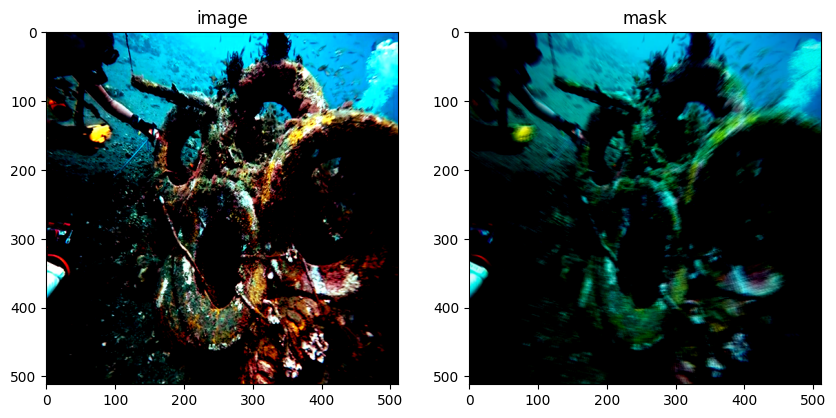

In [19]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.set_title('image')
ax1.imshow(labels[0])
ax2.set_title('mask')
ax2.imshow(features[0])

In [ ]:
augmented = augmentations(image=image.numpy(), mask=mask.numpy())
image, mask = tf.convert_to_tensor(augmented['image']), tf.convert_to_tensor(augmented['mask'])
row=train_df.iloc[4]
img_path,mask_path=row.images,row.masks
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
image,mask=cv2.imread(img_path),cv2.imread(mask_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
ax1.set_title('image')
ax1.imshow(image)
ax2.set_title('mask')
ax2.imshow(mask)

In [ ]:

def get_train_augs():
    return A.Compose([
        A.RandomCrop(height=256, width=256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.VerticalFlip(p=0.5)
    ])

def get_valid_augs():
    return A.Compose([A.RandomCrop(height=256, width=256),    
    ])

In [ ]:

decay_steps = 1000
decay_rate = 0.96
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    config.learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# tf.keras.layers.Dense(units, kernel_initializer='he_normal', bias_initializer='zeros')
# tf.keras.layers.Dense(units, kernel_initializer='he_uniform', bias_initializer='zeros')


In [ ]:
train_set = CrackDatasetTF(train_df, get_train_augs())
train_set = train_set.to_tf_dataset()
train_dataset = train_set .batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
val_set = CrackDatasetTF(val_df, get_valid_augs())
val_set = val_set.to_tf_dataset()
val_dataset = val_set .batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
@tf.function
def compute_loss(logits, labels):
    return tf.reduce_mean(tf.square(logits - labels))

@tf.function
def compute_accuracy(logits, labels):
    # Modify this function according to your specific accuracy calculation needs
    # Example: Calculate the Euclidean distance and check if it's below a certain threshold
    threshold = 0.1
    distance = tf.sqrt(tf.reduce_sum(tf.square(logits - labels), axis=1))
    return tf.reduce_mean(tf.cast(tf.less(distance, threshold), tf.float32))


In [ ]:
###old
@tf.function
def train_one_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss = compute_loss(logits, y)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    accuracy = compute_accuracy(logits, y)
    return loss, accuracy

def evaluate_model(model, validation_ds):
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0

    for x, y in validation_ds:
        logits = model(x, training=False)
        total_loss += compute_loss(logits, y)
        total_accuracy += compute_accuracy(logits, y)
        num_batches += 1

    return total_loss / num_batches, total_accuracy / num_batches

def train(epochs, model, optimizer, train_ds, validation_ds):
    for epoch in range(epochs):
        total_loss = 0.0
        total_accuracy = 0.0
        num_batches = 0

        for step, (x, y) in enumerate(train_ds):
            loss, accuracy = train_one_step(model, optimizer, x, y)
            total_loss += loss
            total_accuracy += accuracy
            num_batches += 1

            if step % 500 == 0:
                print('Epoch', epoch, ': loss', loss.numpy(), '; accuracy', accuracy.numpy())

        train_loss = total_loss / num_batches
        train_accuracy = total_accuracy / num_batches
        val_loss, val_accuracy = evaluate_model(model, validation_ds)

        print(f'Epoch {epoch}: Train Loss: {train_loss.numpy()}, Train Accuracy: {train_accuracy.numpy()}, '
              f'Val Loss: {val_loss.numpy()}, Val Accuracy: {val_accuracy.numpy()}')
model = RSUNet(layers=4, filters=[32, 64, 128, 256, 512],output_channels=3)
train(epochs,model,optimizer,train_ds=train_dataset,validation_ds=val_dataset)

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = RSUNet(layers=4, filters=[32, 64, 128, 256, 512],output_channels=3)
    model.compile(optimizer='adam', 
                  loss=compute_loss, 
                  metrics=[compute_accuracy])

In [ ]:
# model.compile(
#     optimizer=optimizer, 
#     loss=compute_loss, 
#     metrics=[compute_accuracy]
# )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./Checkpoints/best_model.ckpt", 
    save_weights_only=False, 
    save_best_only=True
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=config.epochs,
    validation_data=val_dataset,
    callbacks=[WandbCallback()]  # if you have callbacks
)
wandb.finish()